In [1]:

"""
In this script, we transition from a simple linear model to a small neural network.
We'll use the thermometer calibration data (t_u, t_c) and show how to:
1. Define a neural network with nonlinear activations.
2. Use PyTorch's nn module and an optimizer.
3. Split data into training and validation sets.
4. Train and evaluate the model, plotting both training and validation losses.
"""


"\nIn this script, we transition from a simple linear model to a small neural network.\nWe'll use the thermometer calibration data (t_u, t_c) and show how to:\n1. Define a neural network with nonlinear activations.\n2. Use PyTorch's nn module and an optimizer.\n3. Split data into training and validation sets.\n4. Train and evaluate the model, plotting both training and validation losses.\n"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Explanation:
# - nn: For neural network building blocks (Linear layers, activations, etc.).
# - optim: For gradient-based optimizers (SGD, Adam, etc.).
# - matplotlib: For plotting training and validation losses, as well as final fits.


In [3]:
t_c_list = [0.5, 14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u_list = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# Convert to PyTorch tensors (floats)
t_c = torch.tensor(t_c_list, dtype=torch.float)
t_u = torch.tensor(t_u_list, dtype=torch.float)

# Shuffle indices for train/validation split (80/20)
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices   = shuffled_indices[-n_val:]

# Create training and validation sets
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u   = t_u[val_indices]
val_t_c   = t_c[val_indices]

# Normalize inputs by multiplying by a small factor (e.g., 0.01)
train_t_un = 0.01 * train_t_u
val_t_un   = 0.01 * val_t_u

print("Training samples:", train_t_un.shape[0])
print("Validation samples:", val_t_un.shape[0])


Training samples: 9
Validation samples: 2


In [4]:
class ThermometerNet(nn.Module):
    """
    A simple feedforward neural network with one hidden layer.
    Each layer is a Linear transform, and we use ReLU activation for nonlinearity.
    """
    def __init__(self):
        super().__init__()
        # Hidden layer: from 1 input dimension to 8 neurons
        self.hidden = nn.Linear(1, 8)
        # Output layer: from 8 neurons to 1 output dimension
        self.output = nn.Linear(8, 1)
        # Nonlinear activation
        self.activation = nn.ReLU()

    def forward(self, x):
        # x shape is [N, 1]
        # 1) Hidden layer + activation
        x = self.hidden(x)
        x = self.activation(x)
        # 2) Output layer (linear)
        x = self.output(x)
        return x

# Instantiate the network
model = ThermometerNet()
print("Model structure:\n", model)


Model structure:
 ThermometerNet(
  (hidden): Linear(in_features=1, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
  (activation): ReLU()
)


In [5]:
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.SGD(model.parameters(), lr=1e-2)  # Stochastic Gradient Descent

# Explanation:
# - MSELoss is suitable for continuous output (like temperature).
# - We pick a learning rate of 1e-2; adjust if it diverges or converges too slowly.


In [6]:
def training_loop(n_epochs, model, optimizer, criterion,
                  train_t_u, val_t_u, train_t_c, val_t_c):
    """
    Trains the neural network, logs training and validation losses,
    and returns the loss history.
    """
    train_losses = []
    val_losses   = []

    for epoch in range(1, n_epochs + 1):
        # ----- Training Pass -----
        optimizer.zero_grad()
        # Unsqueeze to make input shape [N, 1]
        t_p_train = model(train_t_u.unsqueeze(1))
        train_loss = criterion(t_p_train, train_t_c.unsqueeze(1))
        train_loss.backward()
        optimizer.step()

        # ----- Validation Pass -----
        with torch.no_grad():
            t_p_val = model(val_t_u.unsqueeze(1))
            val_loss = criterion(t_p_val, val_t_c.unsqueeze(1))

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Print progress every 500 epochs or first few
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch:4d}, Training loss: {train_loss.item():.4f}, "
                  f"Validation loss: {val_loss.item():.4f}")

    return train_losses, val_losses


In [7]:
n_epochs = 3000
train_losses, val_losses = training_loop(
    n_epochs=n_epochs,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_t_u=train_t_un,
    val_t_u=val_t_un,
    train_t_c=train_t_c,
    val_t_c=val_t_c
)


Epoch    1, Training loss: 216.8962, Validation loss: 25.8150
Epoch    2, Training loss: 193.9723, Validation loss: 17.8492
Epoch    3, Training loss: 171.8011, Validation loss: 10.9317
Epoch  500, Training loss: 1.9946, Validation loss: 9.6120
Epoch 1000, Training loss: 1.7462, Validation loss: 9.5442
Epoch 1500, Training loss: 1.7184, Validation loss: 9.5205
Epoch 2000, Training loss: 1.7153, Validation loss: 9.5125
Epoch 2500, Training loss: 1.7150, Validation loss: 9.5098
Epoch 3000, Training loss: 1.7149, Validation loss: 9.5088


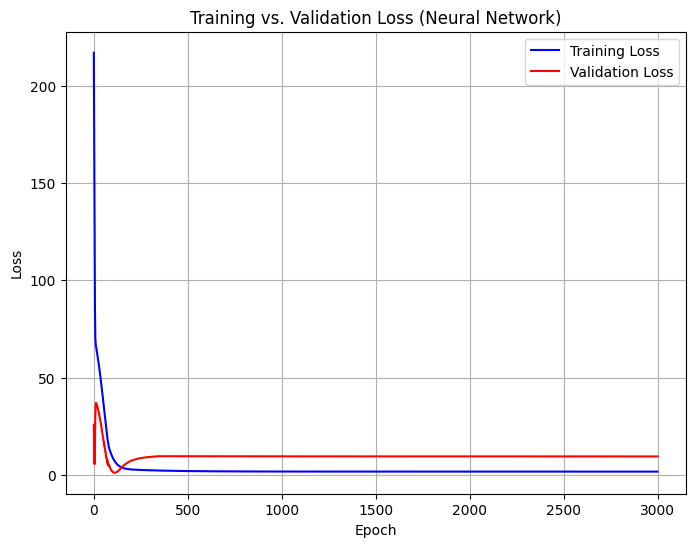

In [8]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses,   label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss (Neural Network)")
plt.legend()
plt.grid(True)
plt.show()

# Explanation:
# - If both curves decrease, the network is learning.
# - If the validation curve diverges, we might be overfitting.
# - If neither decreases, the network might be too simple or the LR is off.


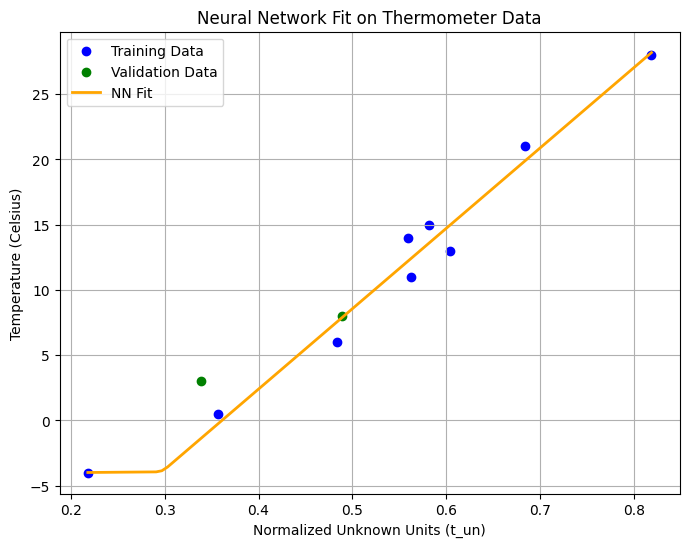

In [9]:
with torch.no_grad():
    # Evaluate model across a range of inputs for a smooth fitted line
    t_u_range = torch.linspace(t_u.min(), t_u.max(), 100)
    t_un_range = 0.01 * t_u_range
    t_p_range = model(t_un_range.unsqueeze(1))

plt.figure(figsize=(8,6))
plt.scatter(train_t_un.numpy(), train_t_c.numpy(), color='blue', label='Training Data')
plt.scatter(val_t_un.numpy(),   val_t_c.numpy(),   color='green', label='Validation Data')
plt.plot(t_un_range.numpy(), t_p_range.numpy(), color='orange', linewidth=2, label='NN Fit')
plt.xlabel("Normalized Unknown Units (t_un)")
plt.ylabel("Temperature (Celsius)")
plt.title("Neural Network Fit on Thermometer Data")
plt.legend()
plt.grid(True)
plt.show()

# Explanation:
# The orange line is the network's learned mapping from t_un to t_c.
# If the data is roughly linear, we might not see a huge difference from a linear model,
# but in more complex tasks, neural networks shine due to their nonlinear layers.